In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas.util.testing as tm # remove error warnings
%matplotlib inline

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# set style of graphs
plt.style.use('ggplot')

In [3]:
# import the dataset
raw_data = pd.read_csv('kc_house_data.csv')

In [4]:
# examine the dataset 
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# looking at this, there are a number of missing values and some columns that will need to be translated
# into a number type

In [6]:
# look at price - - our dependent variable
raw_data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [7]:
# histogram of price to see distribution

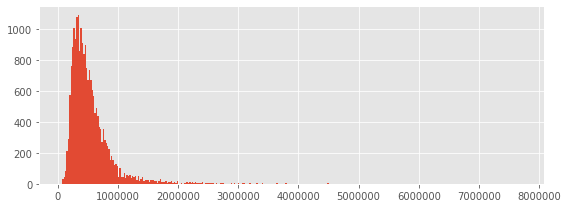

In [8]:
plt.figure(figsize=(8, 3))
raw_data['price'].hist(bins='auto')
plt.tight_layout()

In [9]:
# clear right skew

In [10]:
# 75% of values are less than $650K with the max price being significantly higher than the median of 
# $450K at $7.7M

In [11]:
raw_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
# remove id column as it won't help with regression
clean_data = raw_data.drop('id', axis=1)

In [13]:
clean_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [14]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [15]:
# handle missing values: waterfront, yr_renovated, view are columns with missing values

In [16]:
# Waterfront Missing Values
clean_data['waterfront'].nunique()

2

In [17]:
clean_data['waterfront'].unique()

array([nan,  0.,  1.])

In [18]:
# how many values are nan
clean_data['waterfront'].isna().sum()

2376

In [19]:
# given how many values this is, going to keep the data in for now
# set all nans to 0 as houses missing waterfront information likely do not have waterfronts
clean_data['waterfront'] = clean_data['waterfront'].fillna(value=0.)

In [20]:
# yr_renovated missing values
clean_data['yr_renovated'].nunique()

70

In [21]:
clean_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [22]:
# how many are missing values?
clean_data['yr_renovated'].isna().sum()

3842

In [23]:
# similar to waterfront, going to assume that missing yr_renovated data is likely the result of a house 
# not having a renovation - - reassign all nans to 0.
clean_data['yr_renovated'] = clean_data['yr_renovated'].fillna(value=0.)

In [24]:
# View missing values
clean_data['view'].isna().sum()

63

In [25]:
clean_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [26]:
# view relates to the number of times a house has been viewed -- similar to above assuming that
# missing values are related to houses that have not been viewed -- reassign all nans to 0.
clean_data['view'] = clean_data['view'].fillna(value=0.)

In [27]:
# check for any remaining missing values
clean_data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [28]:
# no more missing values

In [29]:
# check for any duplicates
clean_data.duplicated().any()

False

In [30]:
# there are no duplicates

In [31]:
# Handle strings and convert all columns to appropriate types for regression
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [32]:
clean_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [33]:
# replace '?' with zero as assumption is this relates to houses without a basement
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace(to_replace = '?',
                                                                  value = '0.0')

In [34]:
# convert basement column to a number format
clean_data['sqft_basement'] = clean_data['sqft_basement'].astype('float64')

In [35]:
# handle date column - - convert to a datetime type and then split year, month, and day into separate columns